# Probabilistic Regression - ODSC West 2024

When predicting a numerical target, we are accustomed to "settling" for a mere point estimate.  However, it would be preferable to have a (reliable) probability distribution over the range of possible values.  That is the goal of probabilistic regression.

In this lesson we will demonstrate three packages for Probabilistic Regression:

1) **PrestoBoost**  - this algorithm fits multiple gradient boosting forests on sets of intervals and then averages the resulting densities.  As such, it is nonparametric in nature and the resulting conditional distributions may have "interesting" shapes.  It is part of the `structureboost` package, and therefore can also handle categorical structure in its predictors.
2) **Coarsage**  - also in the `structureboost` package, this algorithm takes the same idea as PrestoBoost but achieves it with a single forest.  For each tree, it (randomly) chooses a coarse set of intervals, calculates the corresponding gradients, and fits a tree to them.
3) (at bottom, for reference) **NGBoost** - uses boosting to find the best fitting parameters for a particular distribution (conditional on the feature values).  It is most typically used with the normal distribution (and a decision tree as the base learner).  It uses the so-called "Natural Gradient" to better fit the set of parameters jointly. 

References: 

B. Lucena "Nonparametric Probabilistic Regression with Coarse Learners". https://arxiv.org/abs/2210.16247

Duan, Tony, et al. "Ngboost: Natural gradient boosting for probabilistic prediction." International conference on machine learning. PMLR, 2020 (https://arxiv.org/abs/1910.03225)



## Imports

In [ ]:
# Uncomment and run these lines if running on Google Colab (or if not installed yet)

# !pip install ml_insights
# !pip install structureboost --no-build-isolation
# !pip install ngboost


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import ngboost as ngb
import structureboost as stb
import ml_insights as mli

import scipy as sp
from sklearn.tree import DecisionTreeRegressor
import time

## Load / Process Dataset
We will start by analyzing the *Concrete* dataset from the UC-Irvine repository.  The goal is to predict the strength of concrete mixtures based on some attributes about the "recipe" which created it.

In [2]:
# Load in data set and clean up the column names
df_concrete = pd.read_csv("https://raw.githubusercontent.com/numeristical/resources/refs/heads/master/ODSC_East_2023/concr_mod.csv")

In [3]:
print(df_concrete.shape)
df_concrete.head()

(1030, 9)


,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_agg,fine_agg,age_days,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


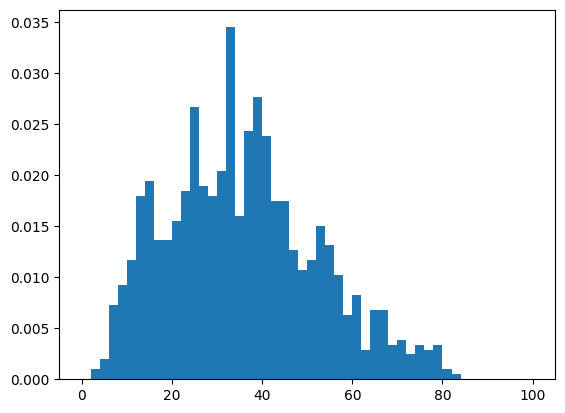

In [4]:
# Here is the marginal probability density 
plt.hist(df_concrete.strength, bins=np.linspace(0,100,51), density=True);

#### Divide into Training / Validation / Test sets

In [5]:
np.random.seed(999)
foldnum = np.random.randint(0,10,df_concrete.shape[0])
pd.Series(foldnum).value_counts()

1    113
3    112
6    110
5    109
0    106
2    106
9    102
7     92
8     90
4     90
Name: count, dtype: int64

In [6]:
# 70% train, 10% valid, 20% test
dfc_train = df_concrete[foldnum<=6]
dfc_valid = df_concrete[(foldnum>6) & (foldnum<=7)]
dfc_test = df_concrete[foldnum>7]

dfc_train_val = pd.concat((dfc_train, dfc_valid))

In [7]:
features = df_concrete.columns[:-1].tolist()
target = 'strength'
X_train = dfc_train.loc[:,features]
y_train = dfc_train[target].to_numpy()

X_valid = dfc_valid.loc[:,features]
y_valid = dfc_valid[target].to_numpy()

X_test = dfc_test.loc[:,features]
y_test = dfc_test[target].to_numpy()

X_train_val = dfc_train_val.loc[:,features]
y_train_val = dfc_train_val[target].to_numpy()


## PrestoBoost
PrestoBoost works by fitting multiple gradient boosting forests to coarsely classify the target into intervals.  The classifier assigns a particular probability to each interval, which can then be converted into a probability density.  Each forest uses a different set of intervals and the resulting densities are averages.  As such, it is a nonparametric methods and makes no assumptions about the form of the distribution (other than a minimum/maximum value). 

StructureBoost is a gradient boosting package that allows the user to incorporate known *structure* of categorical variables so that it can be exploited by the model.  Recently, PrestoBoost was added to the package.  PrestoBoost incorporates some of the structural capabilities of StructureBoost.

References: B. Lucena "Nonparametric Probabilistic Regression with Coarse Learners". https://arxiv.org/abs/2210.16247



In [8]:
pb1 = stb.PrestoBoost(num_forests = 30, num_trees = 100, binpt_sample_size=10)
pb1.fit(X_train, y_train)

Training Forest 0
i=0
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 1
i=0
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 2
i=0
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 3
i=0
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 4
i=0
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 5
i=0
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 6
i=0
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 7
i=0
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 8
i=0
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 9
i=0
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 10
i=0
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 11
i=0
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 12
i=0
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 13
i=0
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
Training Forest 14
i=0
i=10
i=20
i=30
i=40
i=50
i=60
i=70


In [9]:
test_dists_conc = pb1.predict_distributions(X_test)

In [10]:
test_dists_conc.log_loss(y_test)

3.4349936090031243

In [11]:
# We'll use parallelization to speed up the training
pb2 = stb.PrestoBoost(num_forests = 30, num_trees = 100, binpt_sample_size=10)
pb2.fit(X_train, y_train, n_jobs=-1)


Training Forests


In [12]:
pred_dists_pb2 = pb2.predict_distributions(X_test)

In [13]:
pred_dists_pb2.log_loss(y_test)

3.4349936090031243

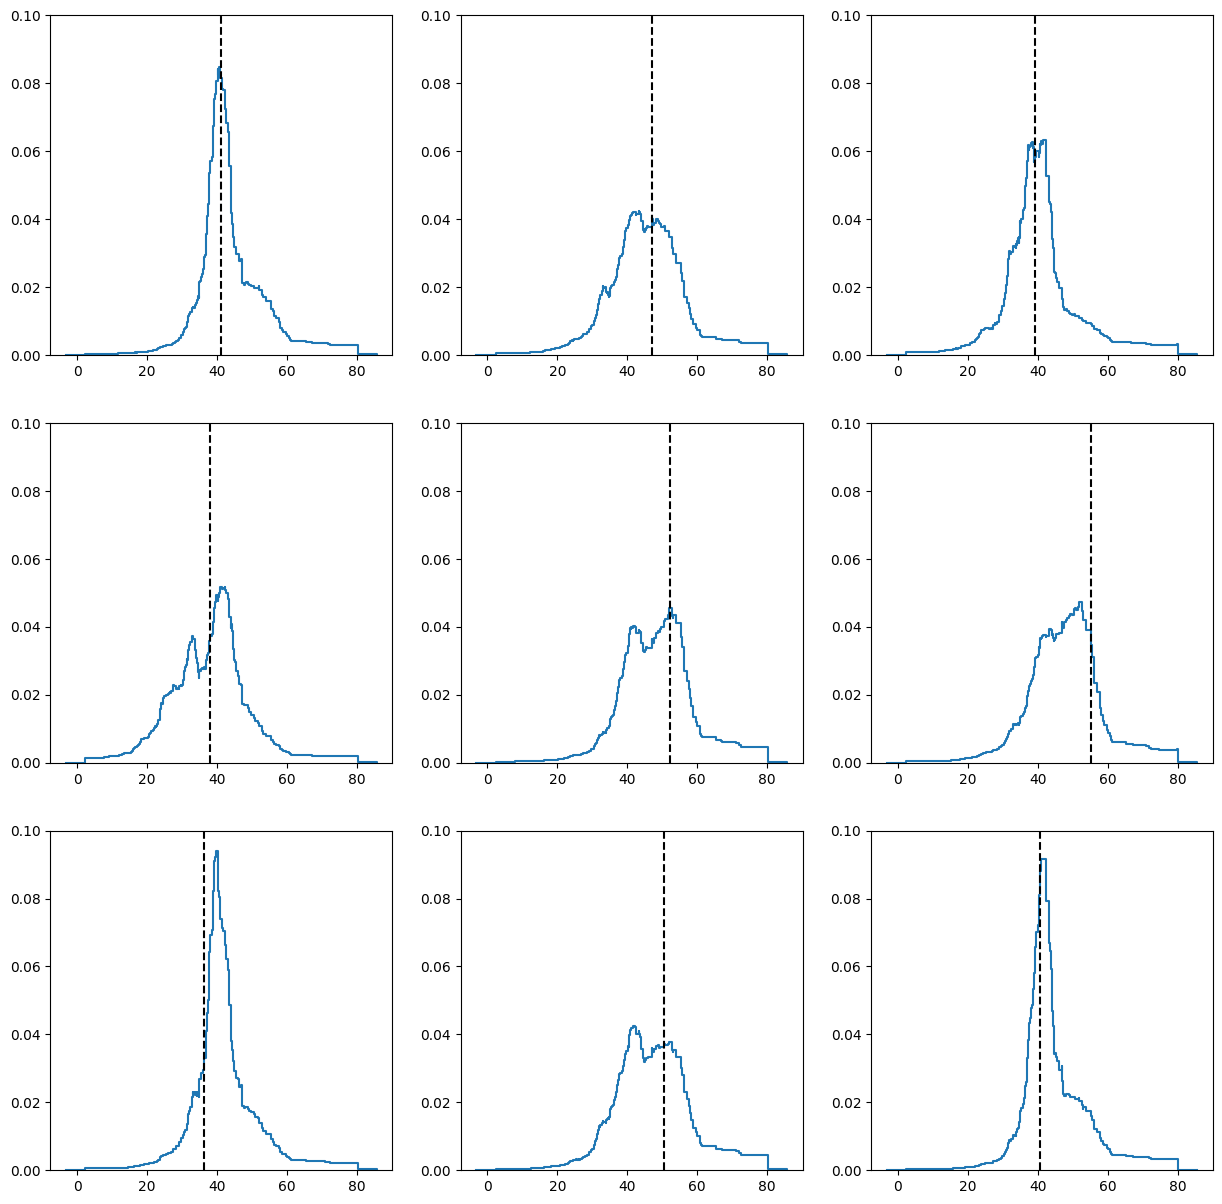

In [14]:
# These are the predicted distributions of the first 9 points of the test set
# Notice the variety of shapes
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    pred_dists_pb2[i].plot_density()
    plt.ylim([0,.1])
    plt.vlines(y_test[i], ymin=0, ymax=.1, color='black', linestyle='--')

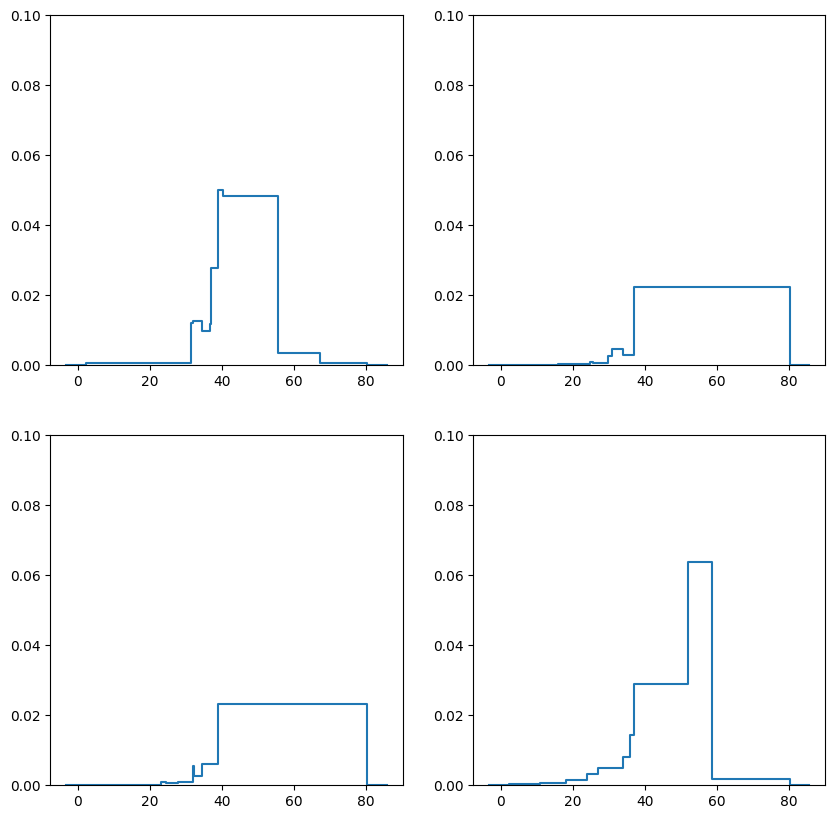

In [15]:
# Let's analyze the center distribution from the above plot
# Below are the predictions from 4 different coarse classifiers
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    pb2.forest_list[i].predict_distributions(X_test[:10])[4].plot_density()    
    plt.ylim([0,.1])

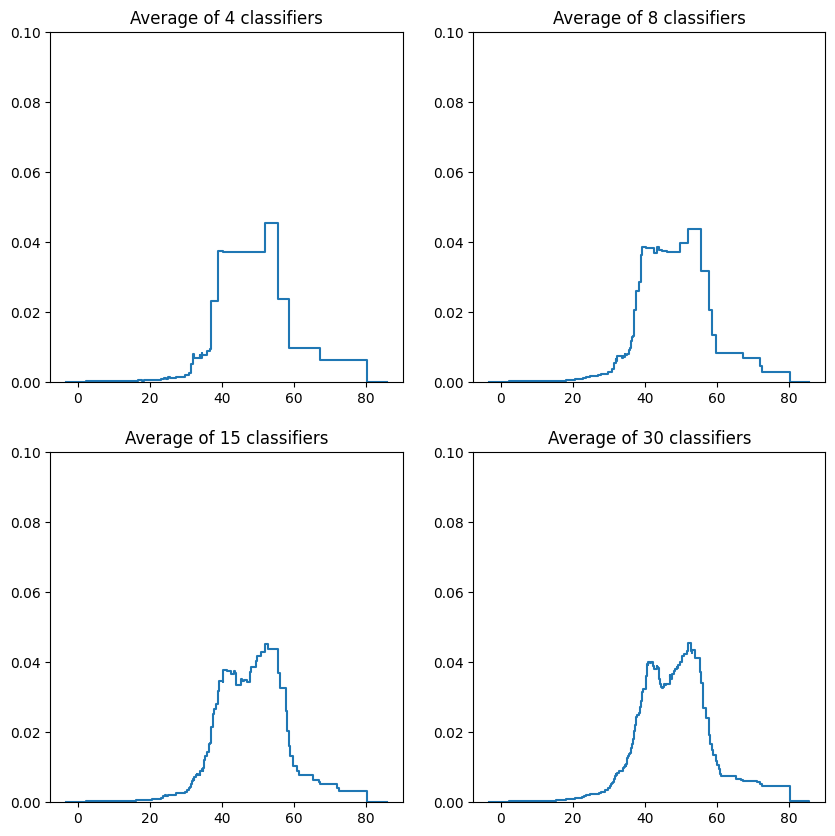

In [16]:
plt.figure(figsize=(10,10))
for i,nf in enumerate([4,8,15,30]):
    plt.subplot(2,2,i+1)
    tmp_test = pb2.predict_distributions(X_test[:20], num_forests_to_use=nf)
    tmp_test[4].plot_density()
    plt.ylim([0,.1])
    plt.title('Average of '+str(nf)+' classifiers')

## Let's optimize the model
PrestoBoost makes it simple to use a validation set for early stopping, and then retrain on the combined training and validation sets.

In [17]:
pb3 = stb.PrestoBoost(num_forests = 30, num_trees = 2000, bin_interp='runif',
                         learning_rate=0.05, binpt_sample_size=25, max_depth=10)
pb3.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps = 2, refit_train_val=True, n_jobs=-1)


Training Forests
Training Forests on combined data


In [19]:
pred_dists_test_pb3 = pb3.predict_distributions(X_test)

In [20]:
pred_dists_test_pb3.log_loss(y_test)

3.0523448026276228

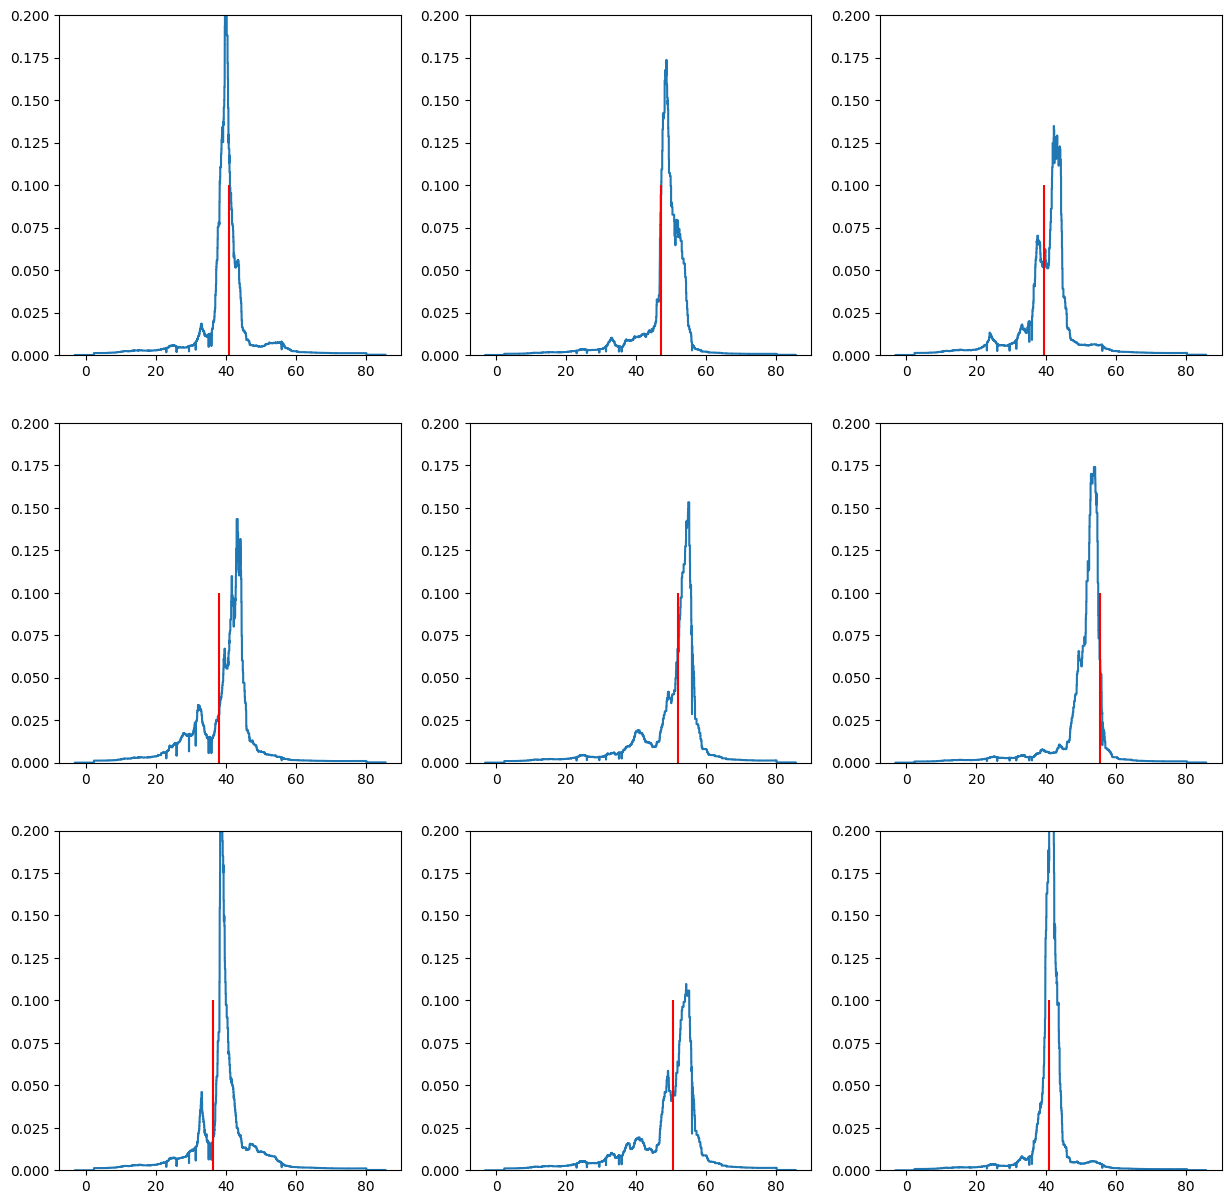

In [21]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    pred_dists_test_pb3[i].plot_density()
    plt.ylim([0,.2])
    plt.vlines(y_test[i], ymin=0, ymax=.1, color='red')

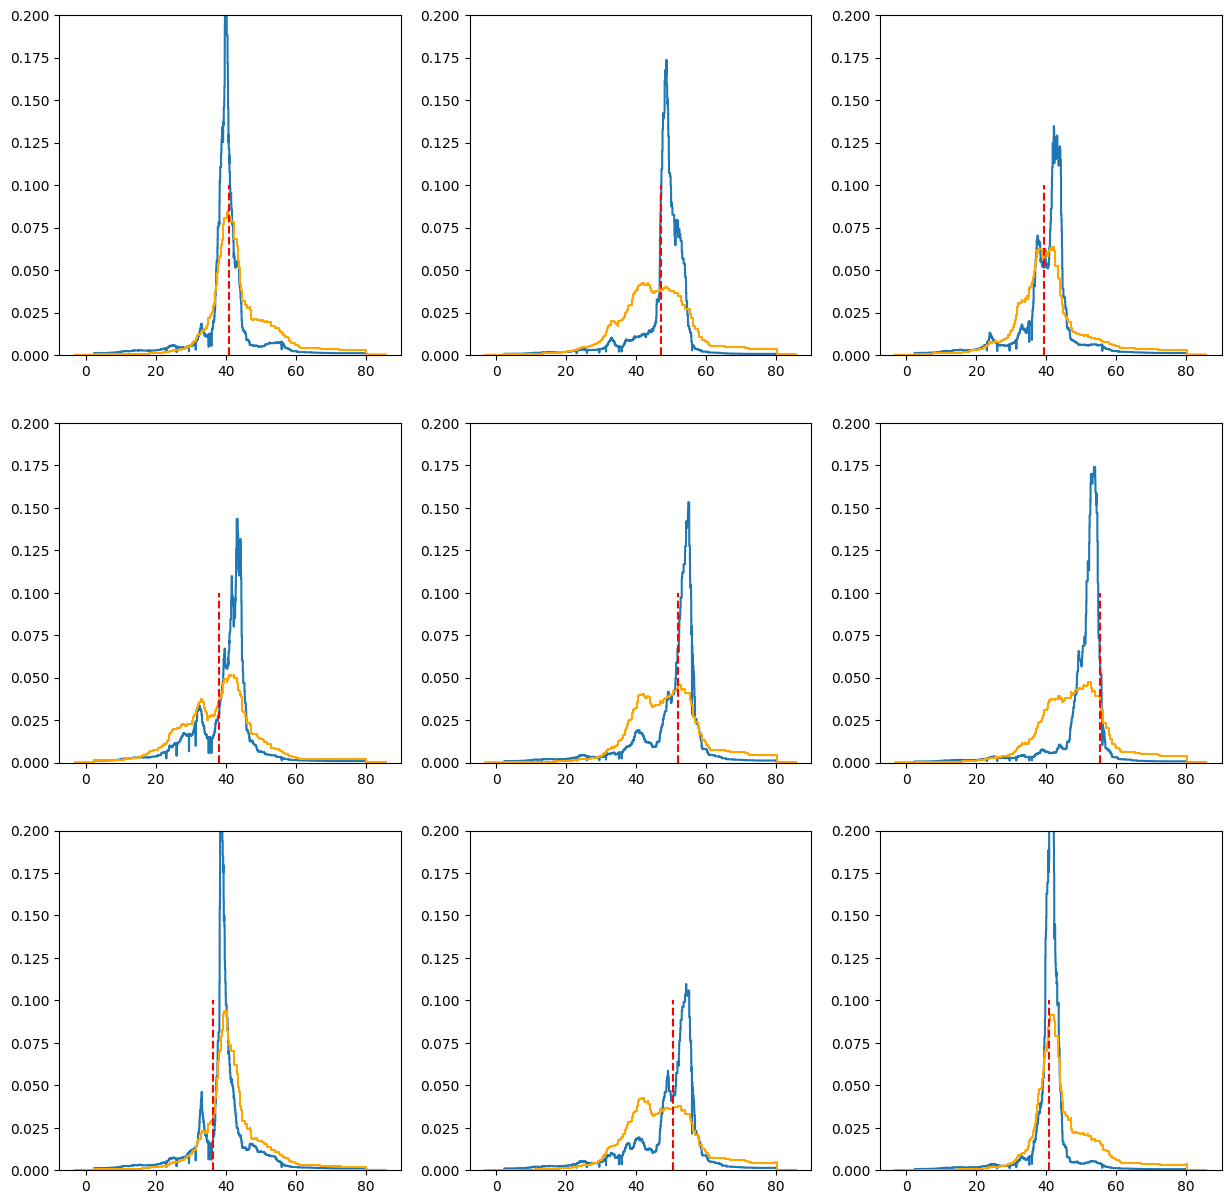

In [22]:
# Compare after optimizing the number of trees in each forest, and using more data
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    pred_dists_test_pb3[i].plot_density()
    pred_dists_pb2[i].plot_density(color='orange')
    plt.ylim([0,.2])
    plt.vlines(y_test[i], ymin=0, ymax=.1, color='red', linestyle='--')

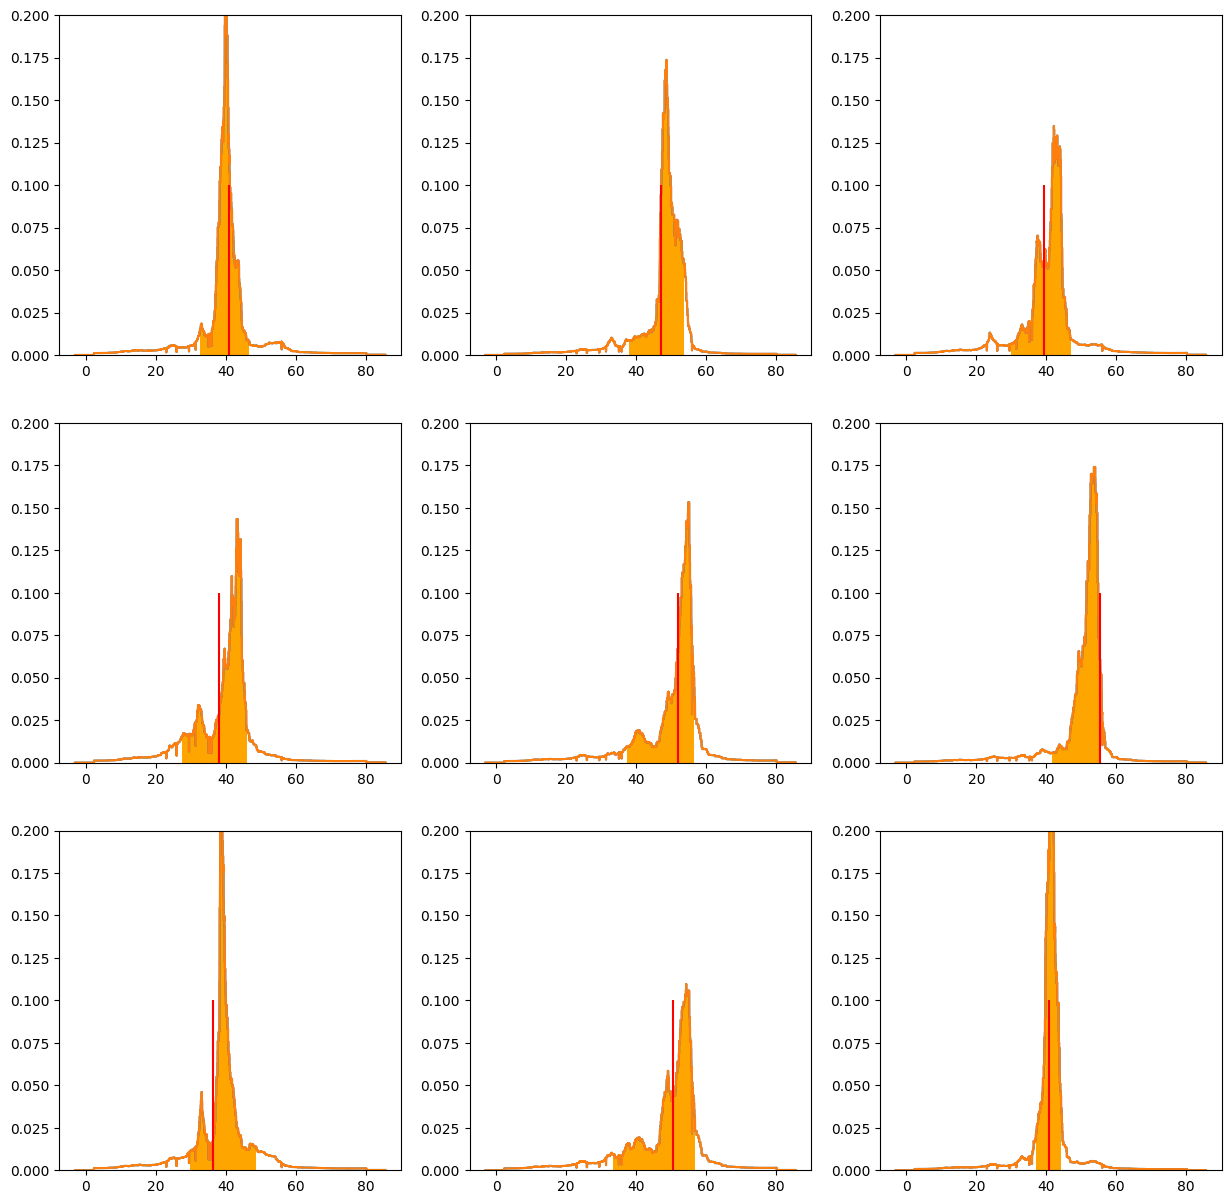

In [23]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    pred_dists_test_pb3[i].plot_density(coverage=.8, pred_type='interval')
    plt.ylim([0,.2])
    plt.vlines(y_test[i], ymin=0, ymax=.1, color='red')

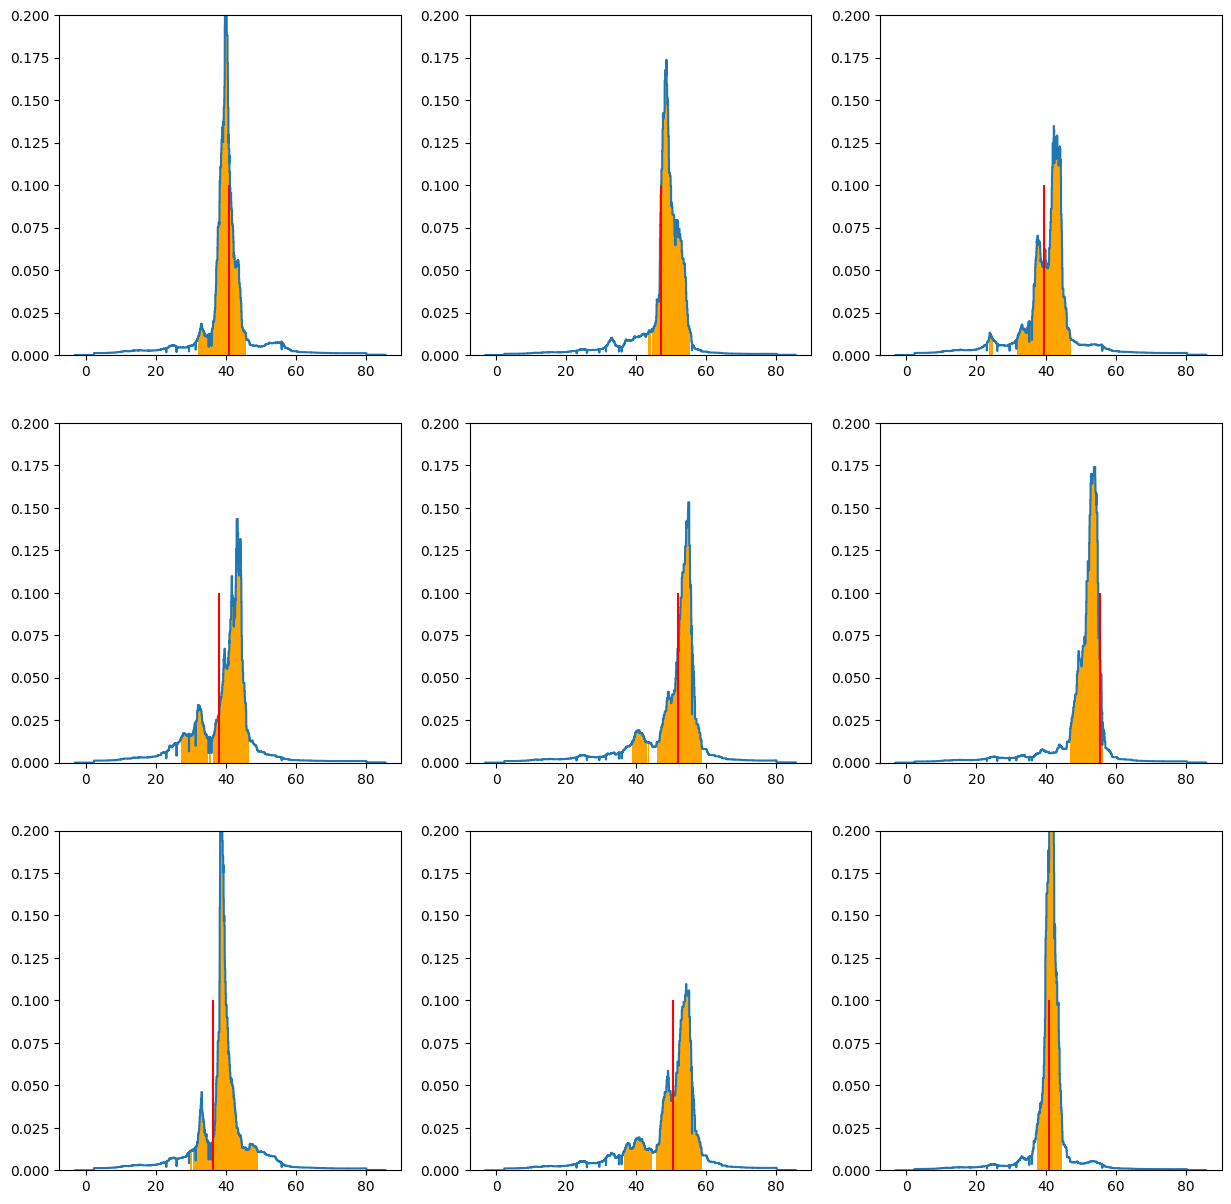

In [24]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    pred_dists_test_pb3[i].plot_density(coverage=.8, pred_type='region')
    plt.ylim([0,.2])
    plt.vlines(y_test[i], ymin=0, ymax=.1, color='red')

## Coverage in Practice
Do the prediction intervals / regions have the desired coverage?

In [25]:
pred_dists_test_pb3.test_between_quantiles(y_test, .025, .975).mean()

0.9895833333333334

In [26]:
pred_dists_test_pb3.test_between_quantiles(y_test, .1, .9).mean()

0.9375

In [27]:
pred_dists_test_pb3.test_in_pred_regions(y_test,.95).mean()

0.9895833333333334

In [28]:
pred_dists_test_pb3.test_in_pred_regions(y_test,.80).mean()

0.9479166666666666

Here, the prediction intervals / regions seem to be conservative - wider than they need to be...

Let's look at the average interval width / region size

In [63]:
pi95_pb3 = pred_dists_test_pb3.quantiles([.025, .975])
np.mean(pi95_pb3[:,1]-pi95_pb3[:,0])

49.49875776501738

In [64]:
pi90_pb3 = pred_dists_test_pb3.quantiles([.05, .95])
np.mean(pi90_pb3[:,1]-pi95_pb3[:,0])

41.714497505701786

In [30]:
pi80_pb3 = pred_dists_test_pb3.quantiles([.1, .9])
np.mean(pi80_pb3[:,1]-pi80_pb3[:,0])

23.70105603271797

In [65]:
pr95_pb3 = pred_dists_test_pb3.pred_region_sizes(coverage=.95)
np.mean(pr95_pb3)

46.58160320258668

In [66]:
pr90_pb3 = pred_dists_test_pb3.pred_region_sizes(coverage=.9)
np.mean(pr90_pb3)

34.13318418286017

In [67]:
pr80_pb3 = pred_dists_test_pb3.pred_region_sizes(coverage=.80)
np.mean(pr80_pb3)

21.77260833390189

### Coarsage
Coarsage (from COARSe ADJustments) works in a similar spirit to PrestoBoost, while only needing a single forest!  Given the current set of predicted distributions, it randomly chooses a set of intervals.  It then computes the (current) predicted probabilities, calculates the gradients, and fits a tree to those gradients.  In adding the tree, it thereby updates the predicted distributions for every point in the training set.  Put simply, it makes a "Coarse Adjustment" to the predicted distributions with every tree that is added to the forest.

In [44]:
cr1 = stb.Coarsage(num_trees=2000, learning_rate=.03, max_depth=8, num_coarse_bins=35)
cr1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps = 5)

i=0, eval_set_loss = 4.139244124692891
i=10, eval_set_loss = 3.9200834292191193
i=20, eval_set_loss = 3.703646913532748
i=30, eval_set_loss = 3.5503985029703107
i=40, eval_set_loss = 3.4343470808100953
i=50, eval_set_loss = 3.362231728510046
i=60, eval_set_loss = 3.2815080740346723
i=70, eval_set_loss = 3.2290415288119583
i=80, eval_set_loss = 3.184022601057186
i=90, eval_set_loss = 3.1475608027377633
i=100, eval_set_loss = 3.130147312594801
i=110, eval_set_loss = 3.097153133531222
i=120, eval_set_loss = 3.0678073890969633
i=130, eval_set_loss = 3.0555619742528375
i=140, eval_set_loss = 3.0384559151459816
i=150, eval_set_loss = 3.0259017181801964
i=160, eval_set_loss = 3.0083240435899765
i=170, eval_set_loss = 2.9949839457370127
i=180, eval_set_loss = 2.9808694810731184
i=190, eval_set_loss = 2.9756429175576686
i=200, eval_set_loss = 2.9760192117227824
i=210, eval_set_loss = 2.971374409544457
i=220, eval_set_loss = 2.965928918338201
i=230, eval_set_loss = 2.9554828679577407
i=240, eval

In [45]:
cr1_preds = cr1.predict_distributions(X_test)
cr1_preds.log_loss(y_test)

2.9803251849875765

In [46]:
cr1.num_trees_for_prediction

290

In [50]:
cr2 = stb.Coarsage(num_trees=cr1.num_trees_for_prediction, learning_rate=.03, 
                   max_depth=8, num_coarse_bins=35)
cr2.fit(X_train_val, y_train_val)


i=0
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
i=100
i=110
i=120
i=130
i=140
i=150
i=160
i=170
i=180
i=190
i=200
i=210
i=220
i=230
i=240
i=250
i=260
i=270
i=280


In [51]:
cr2_preds = cr2.predict_distributions(X_test)
cr2_preds.log_loss(y_test)

2.937989598195564

Let's dive a little bit into how Coarsage works.  We start with the same prediction for every point in X_train.
We get this by the empirical (marginal) distribution of X_train, with respect to a random choice of bins.

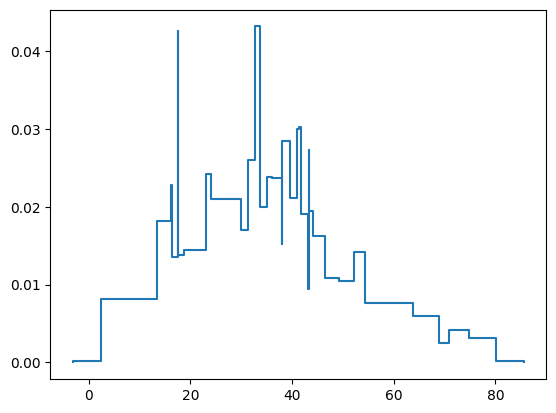

In [52]:
cr2.init_pdf.plot_density()

Then we begin making coarse adjustments based on the randomly chosen bins. We choose a new (random) set of bin pts and calculate the probabilities of being in each bin.  This gives us gradients (for each bin) that we fit with the next tree.

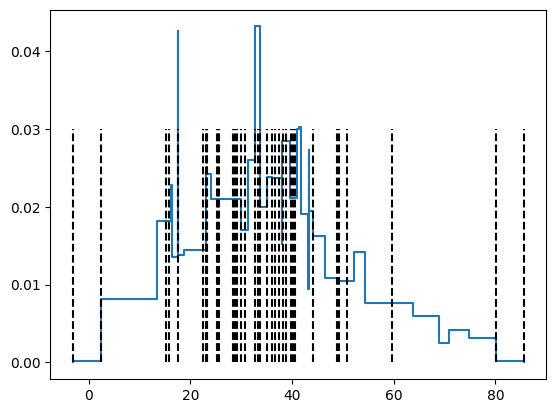

In [53]:
cr2.init_pdf.plot_density()
plt.vlines(x=cr2.binpt_vec_list[0], ymin=0, ymax=0.03, linestyle='--', color='k')

We then calculate the (current) predicted probability in each bin (for each data point) and treat the problem as a multi-class boosting problem, wherein the predicted probability for each of these bins is adjusted upwards or downwards as appropriate.

Below we see how this particular probability distribution evolves over numerous iterations.



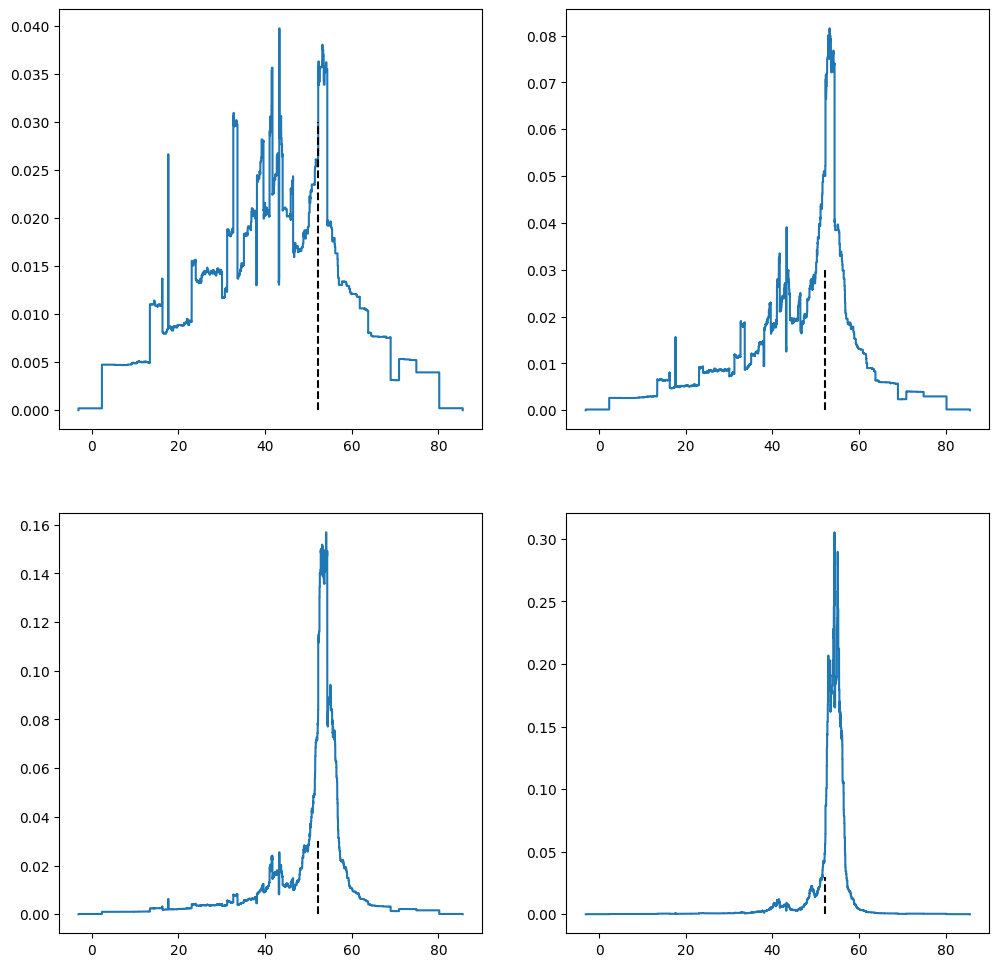

In [54]:
plt.figure(figsize=(12,12))
for i,nf in enumerate([25,50,100,cr2.num_trees_for_prediction]):
    plt.subplot(2,2,i+1)
    tmp_test = cr2.predict_distributions(X_test[:20], num_trees_to_use=nf)
    tmp_test[4].plot_density()
    plt.vlines(x=y_test[4], ymin=0, ymax=0.03, color='k', linestyle='--')
    # plt.ylim([0,.1])
    # plt.title('Average of '+str(nf)+' classifiers')

Let's look at the coverage 

In [55]:
cr2_preds.test_between_quantiles(y_test, .025, .975).mean()

0.9791666666666666

In [56]:
cr2_preds.test_between_quantiles(y_test, .1, .9).mean()

0.890625

In [57]:
cr2_preds.test_in_pred_regions(y_test,.95).mean()

0.9739583333333334

In [58]:
cr2_preds.test_in_pred_regions(y_test,.80).mean()

0.8541666666666666

In [59]:
pi95_cr2 = cr2_preds.quantiles([.025, .975])
np.mean(pi95_cr2[:,1]-pi95_cr2[:,0])

35.542707911045

In [60]:
pi80_cr2 = cr2_preds.quantiles([.1, .9])
np.mean(pi80_cr2[:,1]-pi80_cr2[:,0])

17.327368862493152

In [61]:
pr95_cr2 = cr2_preds.pred_region_sizes(coverage=.95)
np.mean(pr95_cr2)

33.64587111377298

In [62]:
pr80_cr2 = cr2_preds.pred_region_sizes(coverage=.80)
np.mean(pr80_cr2)

15.138305025567822

## Baseball Runs Scored
Here we load in a data set of MLB games.  Each row gives some statistics of the hitting team, the opposing pitchers, and the number of runs that were scored.  We will demonstrate how to predict the distribution of the number of runs scored.

In [2]:
df_runs = pd.read_csv('../ODSC_East_2023/bball_runs_sm.csv')

In [3]:
print(df_runs.shape)

(24284, 13)


In [4]:
df_runs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24284 entries, 0 to 24283
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            24284 non-null  int64  
 1   date_dblhead     24284 non-null  int64  
 2   team_h           24284 non-null  object 
 3   team_v           24284 non-null  object 
 4   home_hitting     24284 non-null  int64  
 5   runs             24284 non-null  int64  
 6   OBP_162          24284 non-null  float64
 7   SLG_162          24284 non-null  float64
 8   Strt_WHIP_35     24284 non-null  float64
 9   Strt_SO_perc_10  24284 non-null  float64
 10  Bpen_WHIP_75     24284 non-null  float64
 11  Bpen_SO_perc_75  24284 non-null  float64
 12  Bpen_WHIP_35     24284 non-null  float64
dtypes: float64(7), int64(4), object(2)
memory usage: 2.4+ MB


In [5]:
df_runs.sample(5, random_state=0)

,index,date_dblhead,team_h,team_v,home_hitting,runs,OBP_162,SLG_162,Strt_WHIP_35,Strt_SO_perc_10,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_WHIP_35
2894,2894,201605090,BOS,OAK,1,14,0.327880,0.430111,1.171053,0.195219,1.256228,0.204282,1.079019
13085,13085,201506150,ANA,ARI,0,7,0.304823,0.373391,1.246575,0.115942,1.263393,0.230519,1.217712
15829,15829,201607050,WAS,MIL,0,5,0.318220,0.394835,1.387755,0.272727,1.143307,0.272727,1.261589
3662,3662,201607040,MIN,OAK,1,1,0.306786,0.406504,1.450607,0.128205,1.349045,0.230129,1.385224
16642,16642,201609070,NYA,TOR,0,0,0.329603,0.443924,1.547619,0.175000,1.185286,0.276382,1.313559


In [6]:
df_runs['runs_trunc'] = np.minimum(df_runs['runs'],16)
df_runs['season']=df_runs.date_dblhead.apply(lambda x: int(str(x)[:4]))

In [7]:
df_runs.season.value_counts()

season
2017    4860
2015    4858
2019    4858
2016    4854
2018    4854
Name: count, dtype: int64

In [8]:
df_train = df_runs[df_runs.season<=2017]
df_valid = df_runs[df_runs.season==2018]
df_test = df_runs[df_runs.season>=2019]

## Begin Modeling

In [9]:
feat_set = ['OBP_162',
 'SLG_162',
 'Strt_WHIP_35',
 'Strt_SO_perc_10',
 'Bpen_WHIP_75',
 'Bpen_SO_perc_75',
 'Bpen_WHIP_35']
target = 'runs'

In [10]:
# def try_features_runs(feat_set, max_depth=2):
target = 'runs_trunc'
X_train = df_train.loc[:,feat_set]
X_valid = df_valid.loc[:,feat_set]
X_test = df_test.loc[:,feat_set]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

For this problem, we know the "bins" we want.  So we can choose `binpt_method='fixed'` and specify the bins we want.

When dealing with integer valued target variables, it is useful to have bins of width 1, so that the density = the probability.  It is also nice for plotting to have the bins centered at the integer values

In [11]:
bpv2 = np.linspace(-.5,16.5,18)
bpv2

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5])

This gives us 17 bins, representing 0, 1, 2, ..., 16+ runs scored for that team

In [12]:
cr1 = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', 
               binpt_vec=bpv2)
cr1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5, eval_freq=10)

i=0, eval_set_loss = 2.4490039762731746
i=10, eval_set_loss = 2.4461026856288144
i=20, eval_set_loss = 2.4441261336702262
i=30, eval_set_loss = 2.442786664662673
i=40, eval_set_loss = 2.441803983073478
i=50, eval_set_loss = 2.441267270938443
i=60, eval_set_loss = 2.4408518677546382
i=70, eval_set_loss = 2.4407273558329554
i=80, eval_set_loss = 2.44048358308717
i=90, eval_set_loss = 2.440753600599292
i=100, eval_set_loss = 2.440887443470512
i=110, eval_set_loss = 2.441246283066303
i=120, eval_set_loss = 2.4415380114590524
i=130, eval_set_loss = 2.441866623289089
Stopping early: low pt was 5 steps ago


In [13]:
preds_test = cr1.predict_distributions(X_test)

In [14]:
preds_test.log_loss(y_test)

2.499823951592217

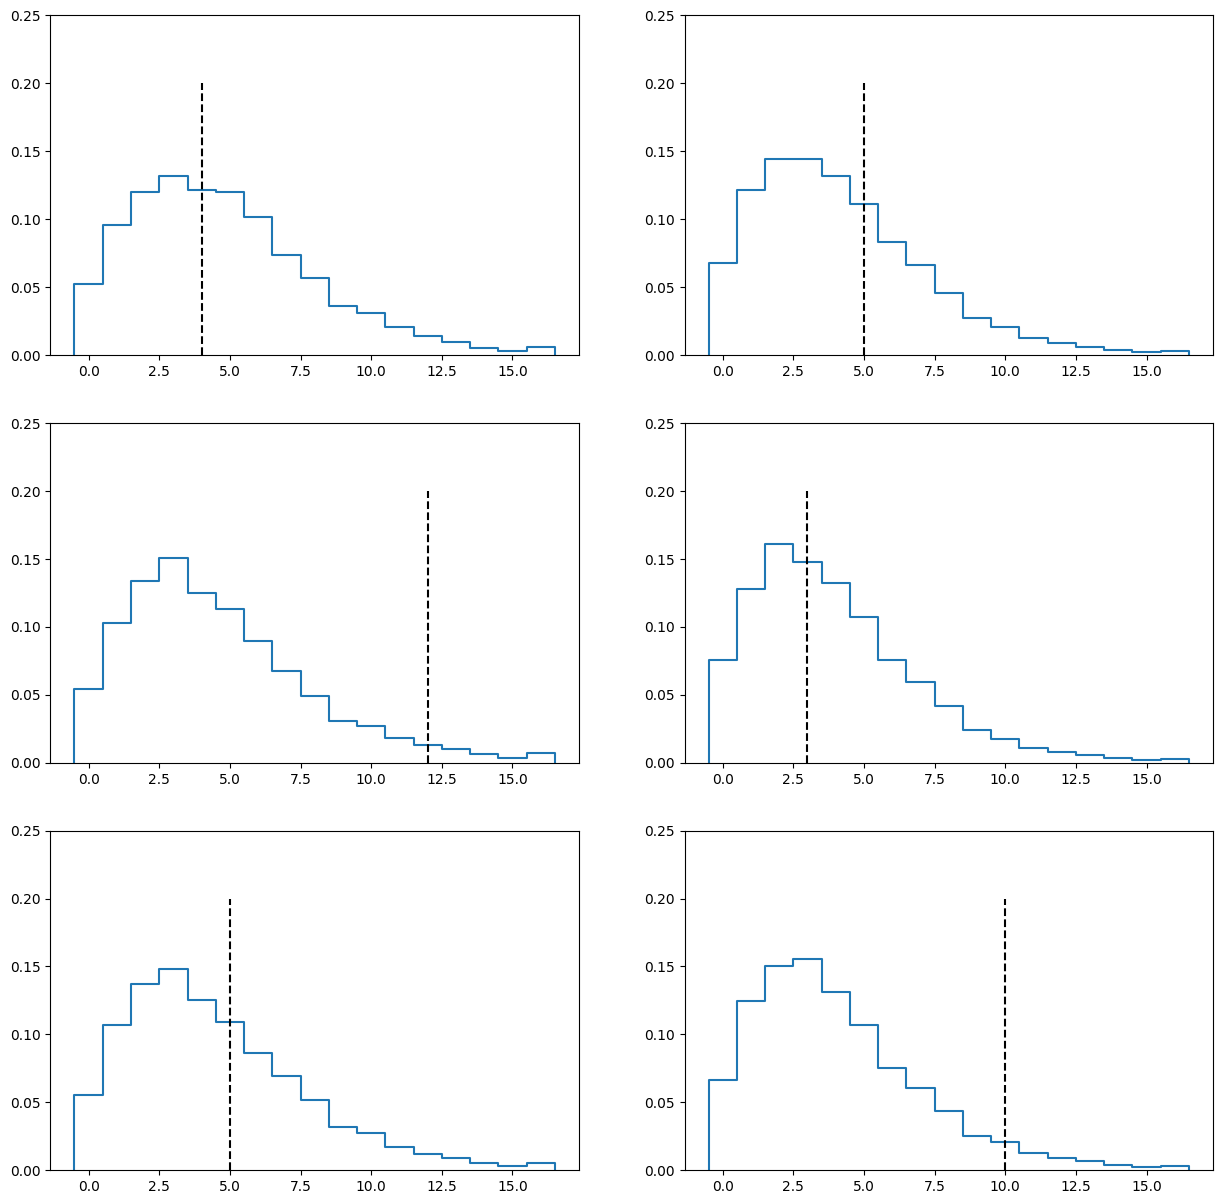

In [15]:
plt.figure(figsize=(15,15))
for i in range(1,7):
    plt.subplot(3,2,i)
    preds_test[i].plot_density()
    plt.ylim([0,.25])
    plt.vlines(x=y_test[i], ymin=0,ymax=.2, color='k', linestyle='--')

When using `binpt_method = 'fixed'` it will always use the exact subdivision it is given.  For a small number of bins, this generally makes sense.  However, if you had a larger number of bins (say 200), you might want to subdivide within the set of given binpts.  To do this, you must choose `binpt_method = 'fixed-rss'` and specify `num_coarse_bins`.

In [16]:
cr2 = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed-rss', num_coarse_bins=10,
               binpt_vec=bpv2)
cr2.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5, eval_freq=10)

i=0, eval_set_loss = 2.4616511642661565
i=10, eval_set_loss = 2.4563420447208775
i=20, eval_set_loss = 2.452244120595677
i=30, eval_set_loss = 2.449880618460853
i=40, eval_set_loss = 2.448330136540596
i=50, eval_set_loss = 2.447064259557887
i=60, eval_set_loss = 2.446170274504683
i=70, eval_set_loss = 2.445114026830268
i=80, eval_set_loss = 2.44473740544833
i=90, eval_set_loss = 2.44462705778871
i=100, eval_set_loss = 2.44427207165758
i=110, eval_set_loss = 2.4444483105772306
i=120, eval_set_loss = 2.4441770915906265
i=130, eval_set_loss = 2.444386906849309
i=140, eval_set_loss = 2.4444449587509065
i=150, eval_set_loss = 2.444627061148494
i=160, eval_set_loss = 2.4447571125733196
i=170, eval_set_loss = 2.444766882252265
Stopping early: low pt was 5 steps ago


In [17]:
preds_test = cr2.predict_distributions(X_test)

In [18]:
preds_test.log_loss(y_test)

2.500932044887411

It is *not* recommended to use `binpt_method='auto'` (the default) when you have integer-valued data (for a variety of reasons).  In some situations it may actually give better log-loss values, but it is effectively "cheating" (you can make log-loss as small as you want by making narrower intervals around the integer values)

Let's look at some of the other parameters in Coarsage:

In [19]:
stb.Coarsage?

Init signature:
stb.Coarsage(
    num_trees,
    max_depth,
    feature_configs=None,
    binpt_method='auto',
    binpt_vec=None,
    num_coarse_bins=30,
    structured_loss=True,
    structure_block_size=None,
    singleton_weight=0.4,
    max_resolution=3000,
    bin_interp='runif',
    range_extension='quantile_frac',
    range_ext_param=(0.25, 0.75, 0.25),
    learning_rate=0.02,
    binpt_growth_wait=0,
    initial_growth_steps=2,
    min_bin_prob=1e-07,
    replace=True,
    min_size_split=25,
    subsample=1,
    gamma=0,
    reg_lambda=1,
    feat_sample_by_tree=1,
    feat_sample_by_node=1,
    random_seed=0,
    initial_model=None,
    na_unseen_action='weighted_random',
    prec_digits=6,
    default_configs=None,
)
Docstring:     
Coarse Adjustment Boosting for Nonparametric Probabilistic Regression.

This method is to be used with a numerical target when you wish to have a
full predicted probability density conditional on the features.

Parameters
----------

num_trees : 

Next, let's revisit the Ames housing data

In [20]:
df_house = pd.read_csv('../GBIP/data/Ames_Housing_Data.tsv', delimiter='\t')
df_house = df_house.loc[df_house['Gr Liv Area']<=4000,:]
df_house['Garage Area'].fillna(0, inplace=True)
df_house.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2925 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2925 non-null   int64  
 1   PID              2925 non-null   int64  
 2   MS SubClass      2925 non-null   int64  
 3   MS Zoning        2925 non-null   object 
 4   Lot Frontage     2435 non-null   float64
 5   Lot Area         2925 non-null   int64  
 6   Street           2925 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2925 non-null   object 
 9   Land Contour     2925 non-null   object 
 10  Utilities        2925 non-null   object 
 11  Lot Config       2925 non-null   object 
 12  Land Slope       2925 non-null   object 
 13  Neighborhood     2925 non-null   object 
 14  Condition 1      2925 non-null   object 
 15  Condition 2      2925 non-null   object 
 16  Bldg Type        2925 non-null   object 
 17  House Style      29

/var/folders/hr/j55bgxq50576_rkv4m06b6zm0000gn/T/ipykernel_88585/1034635011.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_house['Garage Area'].fillna(0, inplace=True)


In [21]:
#df_house.columns = [x.replace(' ','_') for x in df_house.columns]

In [22]:
df_house.sample(5)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
493,494,528294050,80,RL,64.0,7848,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,168000
882,883,907414080,60,RL,64.0,8633,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,2,2009,WD,Normal,173500
1052,1053,528104050,20,RL,114.0,14803,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2008,New,Partial,385000
2618,2619,535426195,20,RL,47.0,16321,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,207500
857,858,907202130,20,RL,NaN,9286,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,143500


In [23]:
feat = ['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
        'Full Bath', 'Half Bath', 'Bedroom AbvGr',
         'Garage Area', 'Fireplaces']

In [24]:
X = df_house.loc[:,feat]  # everything except Sale Price
y = df_house.SalePrice.to_numpy()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 400, random_state=0)

In [26]:
cr3 = stb.Coarsage(num_trees=2000, learning_rate=.03, max_depth=8, num_coarse_bins=20, 
                   binpt_method='fixed-rss', binpt_vec = np.linspace(0,500000,251))
cr3.fit(X_train, y_train, eval_set=(X_test, y_test), early_stop_past_steps = 5)

i=0, eval_set_loss = 12.60489743022037
i=10, eval_set_loss = 12.239773353937471
i=20, eval_set_loss = 12.001704659209317
i=30, eval_set_loss = 11.83017492365515
i=40, eval_set_loss = 11.711001092100735
i=50, eval_set_loss = 11.62392273264756
i=60, eval_set_loss = 11.564249749427404
i=70, eval_set_loss = 11.520865602974963
i=80, eval_set_loss = 11.484822614188994
i=90, eval_set_loss = 11.459514451755794
i=100, eval_set_loss = 11.437748242417683
i=110, eval_set_loss = 11.428529292520068
i=120, eval_set_loss = 11.415142768919614
i=130, eval_set_loss = 11.405782281161326
i=140, eval_set_loss = 11.406038129243393
i=150, eval_set_loss = 11.398946678858078
i=160, eval_set_loss = 11.390280123858712
i=170, eval_set_loss = 11.384048769110644
i=180, eval_set_loss = 11.380938019608198
i=190, eval_set_loss = 11.38071045545355
i=200, eval_set_loss = 11.376716281805107
i=210, eval_set_loss = 11.37516489238104
i=220, eval_set_loss = 11.379889456764353
i=230, eval_set_loss = 11.377735807425342
i=240, e

In [27]:
cr3_preds = cr3.predict_distributions(X_test)
cr3_preds.log_loss(y_test)

11.37516489238104

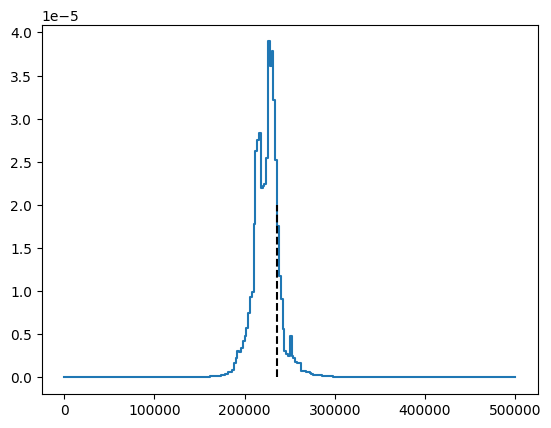

In [28]:
i=0
cr3_preds[i].plot_density()
plt.vlines(x=y_test[i], ymin=0,ymax=.00002, color='k', linestyle='--')

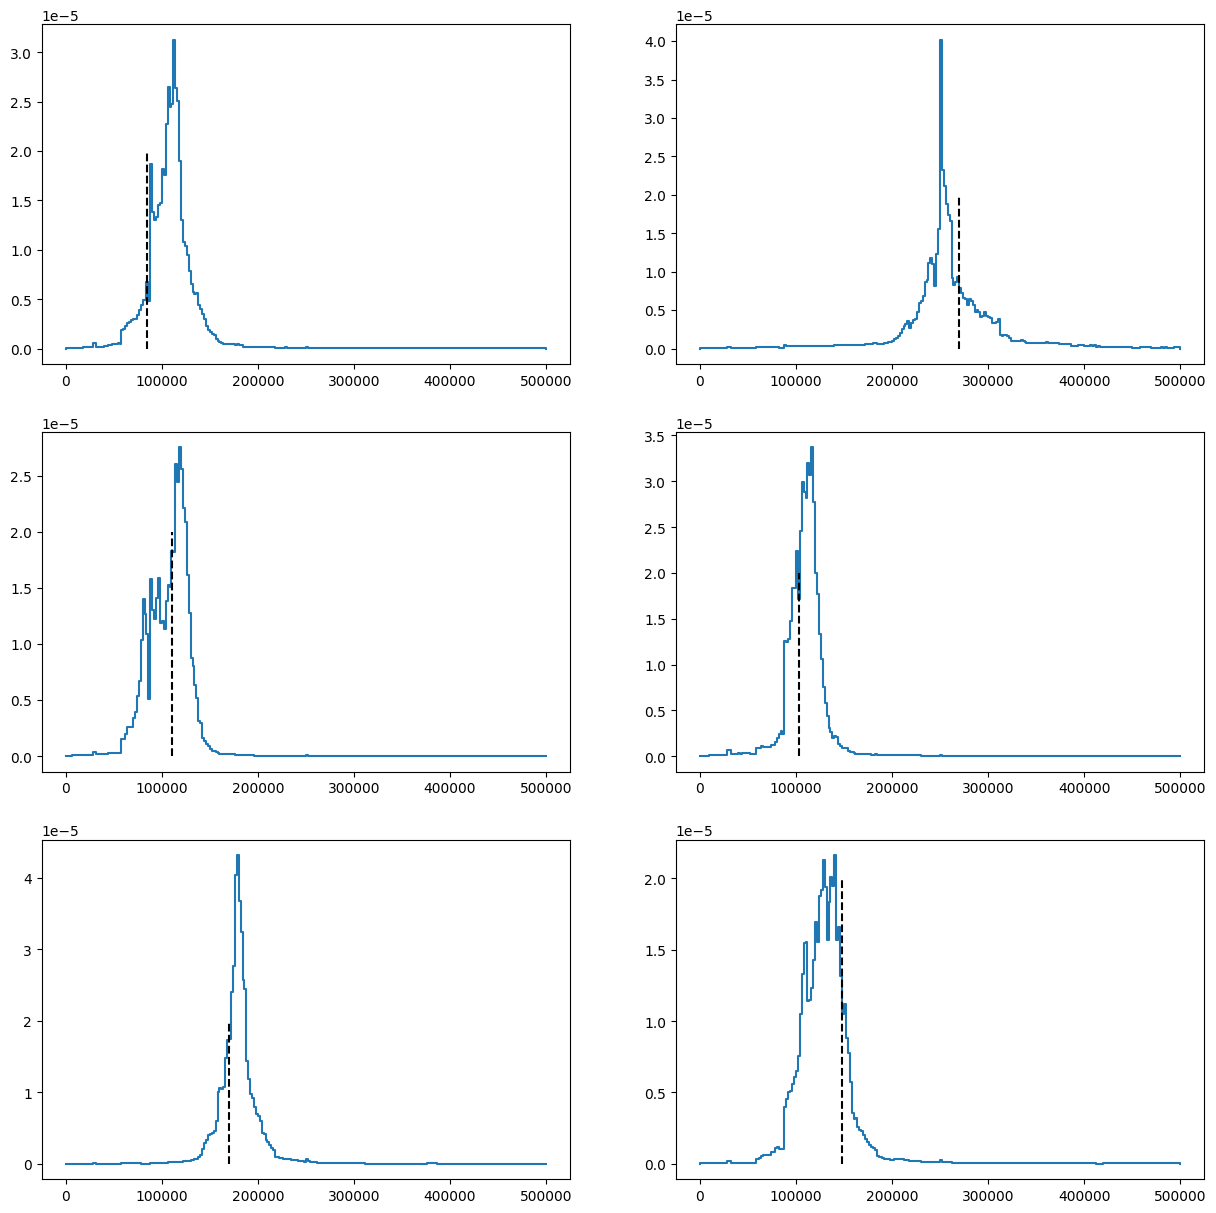

In [29]:
plt.figure(figsize=(15,15))
for i in range(1,7):
    plt.subplot(3,2,i)
    cr3_preds[i].plot_density()
    plt.vlines(x=y_test[i], ymin=0,ymax=.00002, color='k', linestyle='--')

### NGBoost
NGBoost works very much like a typical gradient boosting package.  Under the hood, it is trying to optimize the parameters of the specified distribution for the target variable.  By default, this is the normal distribution, so it uses gradient boosting to fit the mean and variance.  It uses the "natural gradient" which allows it to fit the pair of values more effectively by handling the scaling more efficiently.

In [48]:
ngb1 = ngb.NGBRegressor(n_estimators=500, learning_rate=.01)
ngb1.fit(X_train, y_train)

[iter 0] loss=4.2386 val_loss=0.0000 scale=1.0000 norm=13.4878
[iter 100] loss=3.7669 val_loss=0.0000 scale=2.0000 norm=16.0710
[iter 200] loss=3.3456 val_loss=0.0000 scale=1.0000 norm=5.2890
[iter 300] loss=3.0551 val_loss=0.0000 scale=1.0000 norm=4.2245
[iter 400] loss=2.9041 val_loss=0.0000 scale=2.0000 norm=7.5674


NGBRegressor(random_state=RandomState(MT19937) at 0x106F93840)

In [49]:
# Generally, when you use probabilistic regression you want to get a distribution for each prediction
distr_preds_ngb = ngb1.pred_dist(X_test)

In [50]:
# Let's look inside - we have a "location" and "scale" parameter for each test point
# These are the predicted mean and variance of the normal distribution
distr_preds_ngb.loc[:10], distr_preds_ngb.scale[:10]

(array([41.50408843, 43.95233589, 41.00898558, 37.91638405, 48.58693405,
        47.95370574, 41.51028846, 44.47569646, 43.47636217, 21.29694562]),
 array([4.30691164, 5.1662881 , 4.33693428, 4.1081602 , 4.93674102,
        4.93674102, 4.37846389, 5.1662881 , 4.53465503, 3.3875334 ]))

In [51]:
## To get a point prediction, you can just use `predict`
point_preds_ngb = ngb1.predict(X_test)

In [52]:
# Just gives the mean of the distribution (location)
point_preds_ngb[:10]

array([41.50408843, 43.95233589, 41.00898558, 37.91638405, 48.58693405,
       47.95370574, 41.51028846, 44.47569646, 43.47636217, 21.29694562])

## Evaluating Distributional Predictions
The most common way to evaluate the quality of distributional prediction is the "log-loss", aka the (average) negative log-likelihood of the test data given the predicted distributions.

Essentially, for each test point, you find the predicted probability density at that point, take the log, negate it (to make a loss function) and average across all test points.

In [53]:
# Get the logs of the predicted densities
logpdf_vals_test= distr_preds_ngb.logpdf(y_test)

In [54]:
# Calculate the log_loss
ngb1_log_loss_test = -distr_preds_ngb.logpdf(y_test).mean()
ngb1_log_loss_test

3.2141798215227766

In [55]:
# More detailed way to get these values understand what is going on
# we find the location and scale at each point, calculate the normal density at the test point, and take logs
tmp = np.array([sp.stats.norm(distr_preds_ngb.params['loc'][i],distr_preds_ngb.params['scale'][i]).logpdf(x=y_test[i])
                for i in range(len(y_test))])

# They are in fact the same...
np.allclose(tmp, logpdf_vals_test)

True

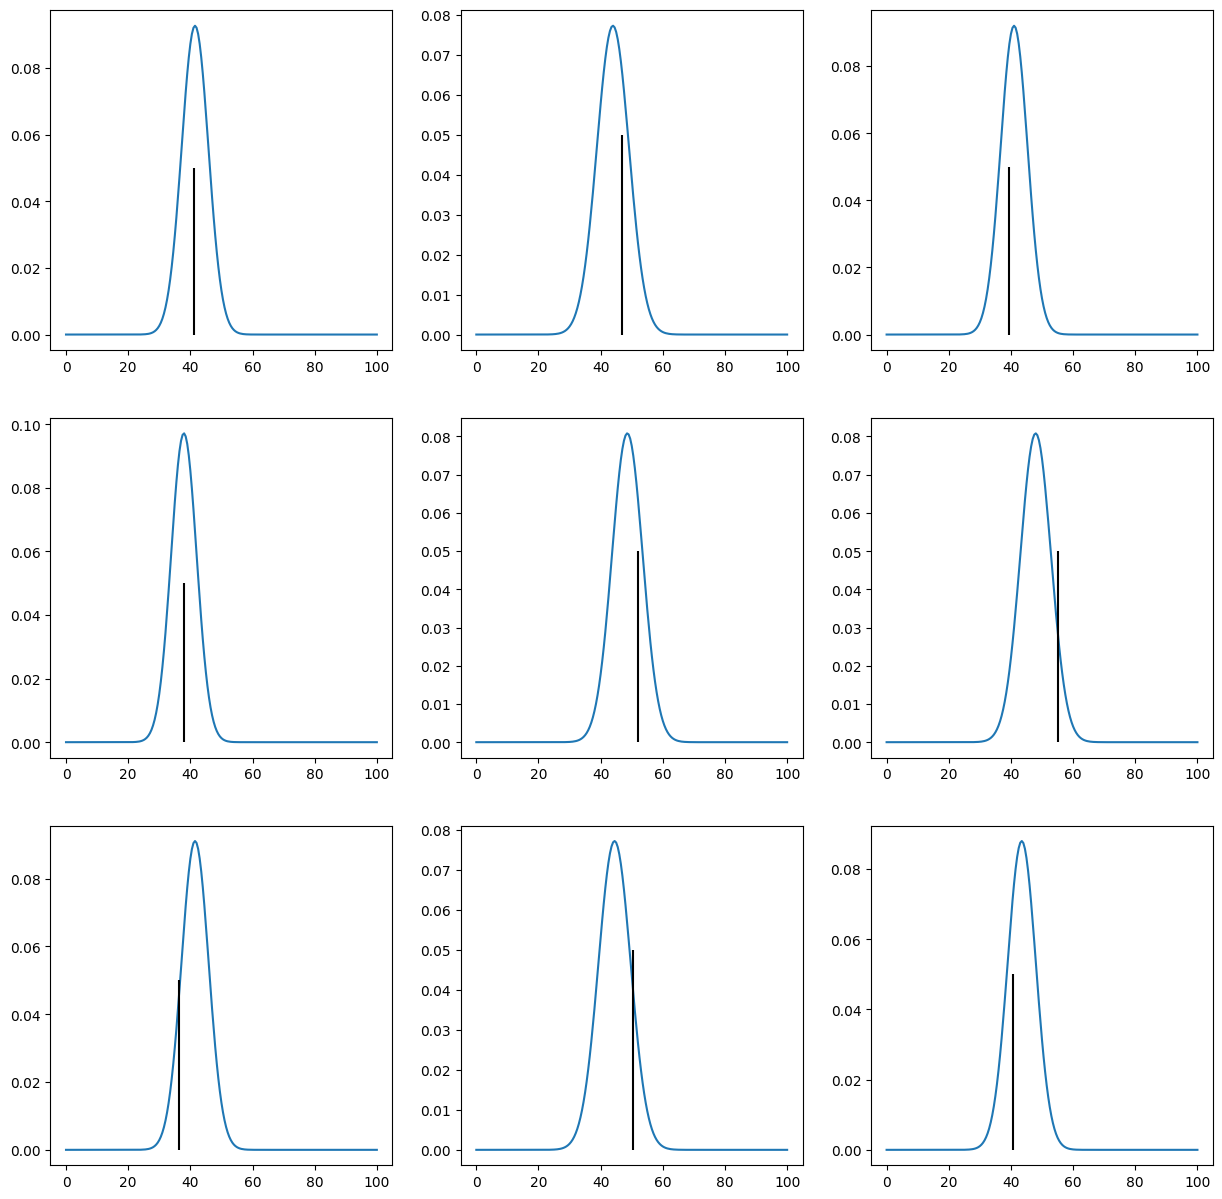

In [56]:
## Plot the distribution for a particular point (and the actual value)
plt.figure(figsize=(15,15))
for index in range(9):
    plt.subplot(3,3,index+1)
    xpts = np.linspace(0,100,201)
    plt.plot(xpts, [sp.stats.norm(distr_preds_ngb.params['loc'][index],distr_preds_ngb.params['scale'][index]).pdf(x) for x in xpts ]);
    plt.vlines(y_test[index], ymin=0, ymax=.05, color='black');

## Prediction Intervals
Another valuable aspect of having a predicted density, is that you can generate confidence intervals.  The simplest way to do this is to look at the quantiles of the predicted distribution.

In [57]:
# Create lists of prediction intervals for the test set (95% and 80%) 
ci95_ngb_test = [sp.stats.norm(distr_preds_ngb.params['loc'][i],
              distr_preds_ngb.params['scale'][i]).interval(.95) for i in range(X_test.shape[0])]

ci80_ngb_test = [sp.stats.norm(distr_preds_ngb.params['loc'][i],
              distr_preds_ngb.params['scale'][i]).interval(.80) for i in range(X_test.shape[0])]

In [58]:
# check each point to see if it is in the interval or not
in_interval_95 = [(y_test[i]>=ci95_ngb_test[i][0]) & 
                 (y_test[i]<=ci95_ngb_test[i][1]) for i in range(X_test.shape[0])]
in_interval_80 = [(y_test[i]>=ci80_ngb_test[i][0]) & 
                 (y_test[i]<=ci80_ngb_test[i][1]) for i in range(X_test.shape[0])]

In [59]:
## Check the coverages
np.mean(in_interval_95), np.mean(in_interval_80)

(0.9010416666666666, 0.6979166666666666)

From the above, it looks like the prediction intervals provide less than the promised coverage...  However, we have not yet optimized the model

## Optimizing the model
Let's optimize the max-depth and number of trees using the validation set.  NGBoost is written generically to take any base estimator- so to change the max-depth you have to do it within the `Base` object.

In [60]:
md_list = []
best_num_trees_list = []
best_ll_val_list = []
for md in range(3,15):
    print(f'max_depth={md}')
    md_list.append(md)
    ngb_tmp = ngb.NGBRegressor(n_estimators=500, learning_rate=.01, 
                               Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=md)
                                )
    ngb_tmp.fit(X_train, y_train)
    
    # "Staged" prediction tries each number of trees within the forest 
    y_forecasts = ngb_tmp.staged_pred_dist(X_valid.to_numpy())
    
    # Get the log_loss for each number of trees in the forest
    val_nll = [-y_forecast.logpdf(y_valid.flatten()).mean() for y_forecast in y_forecasts]
    best_itr = np.argmin(val_nll) + 1
    best_ll_val = np.min(val_nll)
    forecast_val = ngb1.pred_dist(X_valid, max_iter=best_itr)
    best_num_trees_list.append(best_itr)
    best_ll_val_list.append(best_ll_val)
    print(f'for max-depth {md} \n the best log-loss on valid set was {best_ll_val} \n using {best_itr+1} trees')

max_depth=3
[iter 0] loss=4.2386 val_loss=0.0000 scale=1.0000 norm=13.4878
[iter 100] loss=3.7669 val_loss=0.0000 scale=2.0000 norm=16.0710
[iter 200] loss=3.3456 val_loss=0.0000 scale=1.0000 norm=5.2890
[iter 300] loss=3.0551 val_loss=0.0000 scale=1.0000 norm=4.2245
[iter 400] loss=2.9041 val_loss=0.0000 scale=2.0000 norm=7.5674
for max-depth 3 
 the best log-loss on valid set was 3.279752504108799 
 using 344 trees
max_depth=4
[iter 0] loss=4.2386 val_loss=0.0000 scale=1.0000 norm=13.4878
[iter 100] loss=3.6183 val_loss=0.0000 scale=2.0000 norm=13.0238
[iter 200] loss=2.9895 val_loss=0.0000 scale=2.0000 norm=7.1880
[iter 300] loss=2.6396 val_loss=0.0000 scale=1.0000 norm=2.8524
[iter 400] loss=2.4876 val_loss=0.0000 scale=1.0000 norm=2.6008
for max-depth 4 
 the best log-loss on valid set was 3.26070923180776 
 using 208 trees
max_depth=5
[iter 0] loss=4.2386 val_loss=0.0000 scale=1.0000 norm=13.4878
[iter 100] loss=3.3881 val_loss=0.0000 scale=2.0000 norm=9.2902
[iter 200] loss=2.69

In [61]:
best_ind = np.argmin(best_ll_val_list)
md_to_use = md_list[best_ind]
num_trees_to_use = best_num_trees_list[best_ind]
md_to_use, num_trees_to_use

(11, 139)

In [62]:
ngb_opt =  ngb.NGBRegressor(n_estimators=num_trees_to_use, learning_rate=.01, 
                               Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=md_to_use)
                                )
ngb_opt.fit(X_train, y_train)


[iter 0] loss=4.2386 val_loss=0.0000 scale=2.0000 norm=26.9756
[iter 100] loss=3.0244 val_loss=0.0000 scale=2.0000 norm=4.0293


NGBRegressor(Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=11),
             n_estimators=139,
             random_state=RandomState(MT19937) at 0x106F93840)

In [63]:
pred_dists_ngb_opt = ngb_opt.pred_dist(X_test)

In [64]:
-pred_dists_ngb_opt.logpdf(y_test).mean()

3.21674037266173

In [65]:
# Create lists of prediction intervals for the test set (95% and 80%) 
ci95_ngb_test_opt = [sp.stats.norm(pred_dists_ngb_opt.params['loc'][i],
              distr_preds_ngb.params['scale'][i]).interval(.95) for i in range(X_test.shape[0])]

ci80_ngb_test_opt = [sp.stats.norm(pred_dists_ngb_opt.params['loc'][i],
              distr_preds_ngb.params['scale'][i]).interval(.80) for i in range(X_test.shape[0])]

In [66]:
# check each point to see if it is in the interval or not
in_interval_95_opt = [(y_test[i]>=ci95_ngb_test_opt[i][0]) & 
                 (y_test[i]<=ci95_ngb_test_opt[i][1]) for i in range(X_test.shape[0])]
in_interval_80_opt = [(y_test[i]>=ci80_ngb_test_opt[i][0]) & 
                 (y_test[i]<=ci80_ngb_test_opt[i][1]) for i in range(X_test.shape[0])]

In [67]:
## Check the coverages
np.mean(in_interval_95_opt), np.mean(in_interval_80_opt)

(0.875, 0.7916666666666666)

Still not getting the promised coverage for 95%, though we are close for the 80% interval

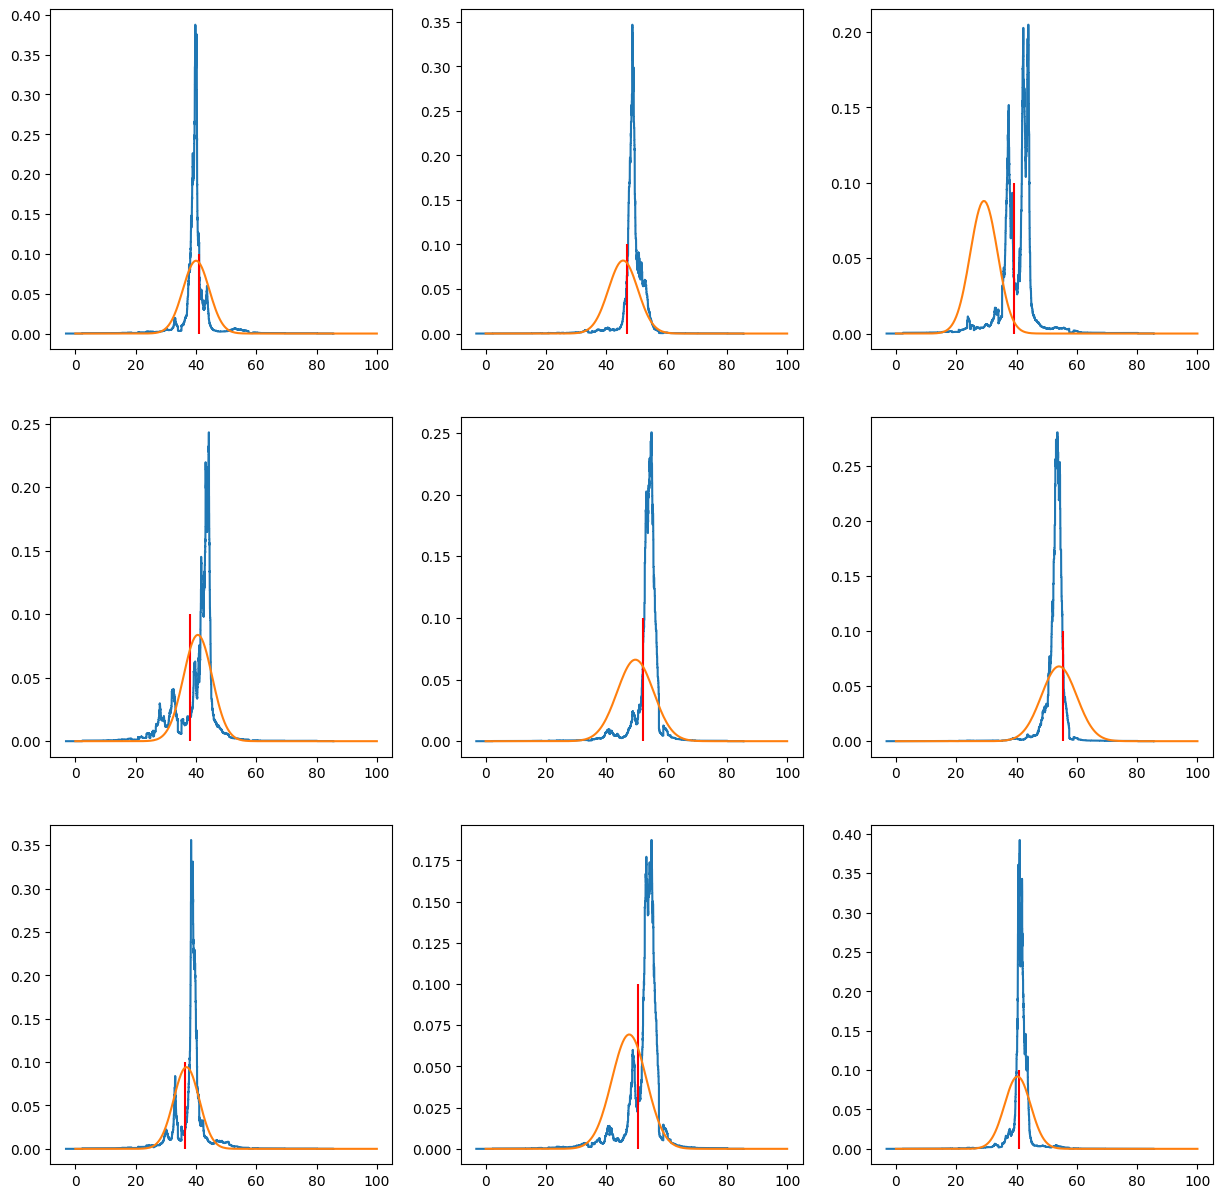

In [68]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    cr2_preds[i].plot_density()
    plt.vlines(y_test[i], ymin=0, ymax=.1, color='red')    
    xpts = np.linspace(0,100,201)
    plt.plot(xpts, [sp.stats.norm(pred_dists_ngb_opt.params['loc'][i],pred_dists_ngb_opt.params['scale'][i]).pdf(x) for x in xpts ]);
